## SimCLR Training

In [1]:
# For VSCode
%load_ext autoreload
%autoreload 2

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt

sys.path.append('../../')   # Add parent directory to Python path
working_directory = "../../models/"

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data
with open('../../data/TrainTest_one/X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
np_train_data.shape, np_train_labels.shape

((848, 50, 3), (848, 7))

In [ ]:
# For Google Colab

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import simclr_utitlities
import transformations
import simclr_models
import sys

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)




In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/your_project_folder/')
# working_directory = "/content/drive/MyDrive/your_project_folder/models/"
sys.path.append('../../')   # Or adjust as needed
working_directory = "../../models/"


# If files are in Google Drive, adjust the path accordingly
# Example: '/content/drive/MyDrive/your_project_folder/data/TrainTest_one/X_train_data_normalized.pkl'
with open('../../data/TrainTest_one/X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
np_train_data.shape, np_train_labels.shape

In [ ]:
# Parameters for all experiments
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [17]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized, 
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized, 
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized, 
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized, 
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized, 
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved, 
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost, 
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized, 
#     indices=transformation_indices
# )

In [18]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved, 
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x000001B48BB116C0>
1 <function channel_shuffle_transform_vectorized at 0x000001B48BB11620>


In [24]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).

In [37]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model, 
    np_train_data, 
    optimizer, 
    batch_size, 
    transformation_function,
    temperature=temperature, 
    epochs=epochs, 
    is_trasnform_function_vectorized=True, 
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 13.310
epoch: 2 loss: 13.148
epoch: 3 loss: 12.630
epoch: 4 loss: 11.576
epoch: 5 loss: 11.524
epoch: 6 loss: 11.744
epoch: 7 loss: 11.189
epoch: 8 loss: 10.384
epoch: 9 loss: 10.123
epoch: 10 loss: 10.339
epoch: 11 loss: 9.866
epoch: 12 loss: 10.511
epoch: 13 loss: 10.505
epoch: 14 loss: 10.486
epoch: 15 loss: 9.878
epoch: 16 loss: 10.525
epoch: 17 loss: 9.638
epoch: 18 loss: 9.268
epoch: 19 loss: 9.369
epoch: 20 loss: 9.737
epoch: 21 loss: 9.211
epoch: 22 loss: 9.441
epoch: 23 loss: 9.352
epoch: 24 loss: 8.992
epoch: 25 loss: 8.745
epoch: 26 loss: 8.831
epoch: 27 loss: 9.307
epoch: 28 loss: 8.933
epoch: 29 loss: 8.824
epoch: 30 loss: 8.955
epoch: 31 loss: 9.010
epoch: 32 loss: 8.524
epoch: 33 loss: 9.261
epoch: 34 loss: 9.096
epoch: 35 loss: 9.549
epoch: 36 loss: 8.734
epoch: 37 loss: 8.393
epoch: 38 loss: 8.844
epoch: 39 loss: 8.685
epoch: 40 loss: 8.133
epoch: 41 loss: 8.231
epoch: 42 loss: 8.617
epoch: 43 loss: 8.262
epoch: 44 loss: 8.591
epoch: 45 loss: 8.318
epoch

epoch: 199 loss: 5.855
epoch: 200 loss: 5.737


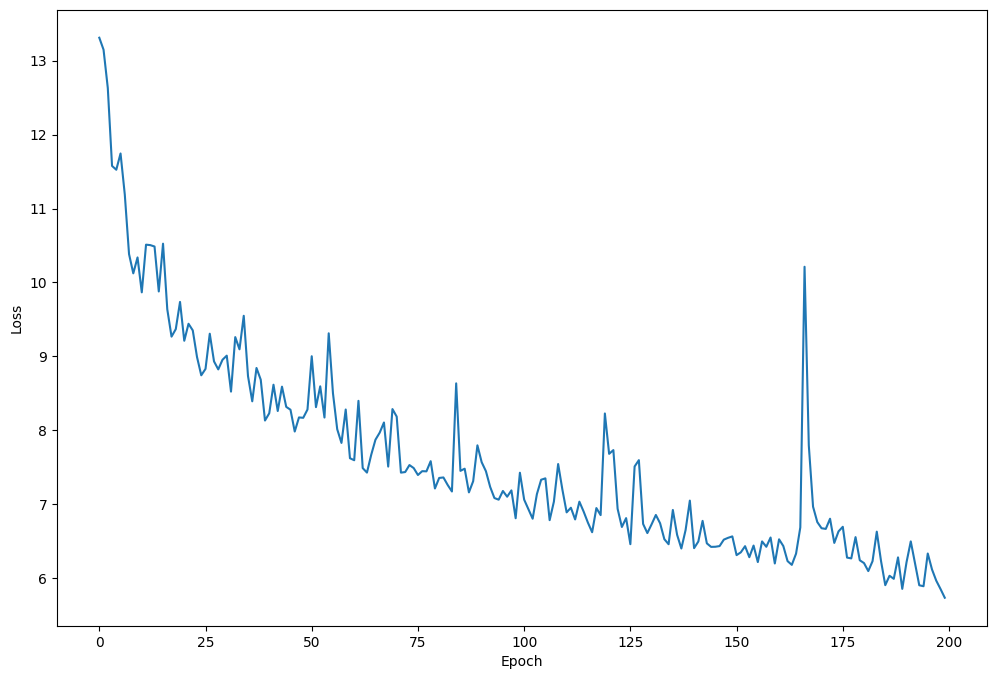

In [38]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()